### Imports

In [119]:
import sympy as sym
import numpy as np
from numpy.random import randn # Gaussian random number'
%matplotlib inline
import matplotlib.pyplot as plt

### Derivative of y

In [120]:
x1, x2 = sym.symbols('x1 x2') 

n = 500
sigma = 10
sigma2 = 2*sigma**2
lam = 0.000001

x = randn(n)/2

x1_example = randn(n)/2
x2_example = randn(n)/2

noise = n * 1e-1
#y1 = 1+ sym.sin(x1/10) + x1**2 + noise
y1 = 1 + sym.sin(x1) + noise
y2 = 0.5 * x2**2 + sym.exp(x2) + noise

# derivate y1, y2 with respect to x1, x2 (sympy)
y1_diff = y1.diff(x1)
y2_diff = y2.diff(x2)

# Put back to numpy functions
y1_derivative = sym.lambdify(x1, y1_diff, 'numpy') 
y2_derivative = sym.lambdify(x2, y2_diff, 'numpy')

# Apply derivative functions to the x-arrays that we have in the beginning
y1_derivative = y1_derivative(x1_example)
y2_derivative = y2_derivative(x2_example)

y_derivative = np.array(np.ravel([y1_derivative, y2_derivative], 'F'))

### Gradient of f

In [121]:
# x,z = [x[:,i], x[:,j]]
# sym.exp(-((sym.sqrt(sympv.dot(x-z, x-z)))**2)/(2*sigma**2)) (with sympy)

x1 = randn(n)/2
x2 = randn(n)/2
x_vector = np.array([x1, x2])

def k_gauss(x, z):
    k = np.exp(-((np.linalg.norm(x-z))**2)/(2*sigma**2))
    return k

# Derivative of the gaussian kernel w.r.t. x
def k_gauss_derivative_wrt_x(x, z):
    kernel_gauss = k_gauss(x, z) # I formel er x - z tall, ikke vektorer
    k_derivative = -(kernel_gauss*(x-z)/sigma**2)
    return k_derivative

# Derivative of the gaussian kernel w.r.t. x and z
def k_gauss_derivative_wrt_x_and_z(x, z):
    kernel_gauss = k_gauss(x, z)
    k_derivative = -((x-z)**2-sigma**2)/(kernel_gauss*sigma**4)
    return k_derivative

def K_gauss_derivative_wrt_x(x, z, n):
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = k_gauss_derivative_wrt_x(x[i], z[j])
    return K
    
# Alpha for gauss_kernel with respect to x
def alpha_gauss_derivative(x, y, n):
    K = K_gauss_derivative_wrt_x(x, x, n)
    return np.linalg.inv(K + lam*np.eye(n)) @ y

def func_gauss_derivative(x, n, alpha):
    x_sort = np.sort(x)
    f = np.zeros(n)
    for i in range(n):
        sum = 0
        for j in range(n):
            sum = sum + alpha[j] * k_gauss_derivative_wrt_x(x_sort[i], x[j])
        f[i] = sum
    return f

alpha = alpha_gauss_derivative(x1_example, y1_derivative, n)
func = func_gauss_derivative(x1_example, n, alpha)
y1_sorted = np.sort(y1_derivative)
print(func)

[ 0.10976051  0.13207269  0.15042595  0.19786253  0.23534961  0.28894033
  0.30342232  0.30666816  0.35763341  0.43187325  0.44493944  0.44823212
  0.4812242   0.49309151  0.49695715  0.50031541  0.51022183  0.51236266
  0.51954513  0.57106603  0.57717088  0.59522354  0.62237823  0.68161237
  0.68203581  0.68358213  0.69578653  0.70152132  0.70715457  0.71402451
  0.71642757  0.72439207  0.73291869  0.73635177  0.74405808  0.76211149
  0.76702353  0.77856807  0.78777151  0.7927587   0.80051415  0.81071164
  0.82029324  0.82048386  0.83148498  0.83224308  0.84000498  0.84029958
  0.84348063  0.84349584  0.84432113  0.84870925  0.8527519   0.8530256
  0.86009466  0.86611255  0.8702675   0.87031059  0.87280606  0.87462794
  0.87512378  0.87971742  0.88039074  0.88073826  0.88462207  0.89338276
  0.89540687  0.89859799  0.90074717  0.90168023  0.90284763  0.90398536
  0.90630624  0.90798398  0.91230112  0.91263413  0.91403584  0.91452375
  0.91598079  0.9160225   0.9167054   0.91755428  0.

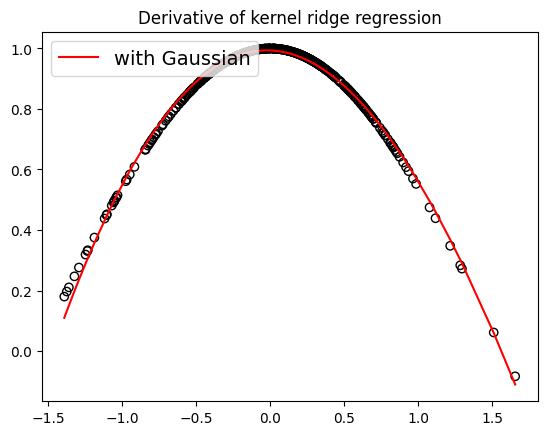

In [122]:
x1_sort = np.sort(x1_example)

plt.scatter(x1_example, y1_derivative, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(x1_sort, func, c="r", label="with Gaussian")
plt.title("Derivative of kernel ridge regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 14 } )
plt.show()